In [1]:
from matplotlib import style
style.use('dark_background')

In [2]:
import numpy as np
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [3]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
from tqdm import tqdm
tqdm.pandas()

C:\Users\Dima\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
RS = 7345

# Загрузка данных

In [7]:
train = pd.read_csv("train.csv", index_col="pair_id")
test = pd.read_csv("test.csv", index_col="pair_id")

In [8]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [9]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [12]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [13]:
train[train.is_duplicate==1].sample(5)

,name_1,name_2,is_duplicate
pair_id,,,
299025,SERVICOM (OFF-SPEC),Servicom S.A. (BVMT:SERVI) - سرفيكوم,1
377179,BINNE,Binne & Sohn GmbH & Co KG,1
426526,Fenner USA,"Fenner Dunlop (Toledo), Llc",1
312218,SOPREMA OBERROSSBACH,SOPREMA S.A.S.,1
157890,"Arlanxeo Singapore Pte., Ltd.",Arlanxeo Usa Llc,1


In [14]:
train[train.is_duplicate==0].sample(5)

,name_1,name_2,is_duplicate
pair_id,,,
316061,Ecopmin Technologies Private Ltd.,Acero Tecnologia Sa De Cv,0
316461,"Symtake Chemical Co., Ltd.",Guy Chemical,0
359433,Eriks Industries Services Lp,Zhejiang Materials Industries Chemica,0
278515,BATEC GROUP GmbH,ISOLAGO S.A.,0
182528,Colamid Do Brasil Ltda,Ctl Logistics Do Brasil Ltda,0


# Очистка данных

In [15]:
from unidecode import unidecode

In [16]:
# Переведем строки в юникод 
train["name_1"] = train["name_1"].apply(lambda x: unidecode(x))
train["name_2"] = train["name_2"].apply(lambda x: unidecode(x))

test["name_1"] = test["name_1"].apply(lambda x: unidecode(x))
test["name_2"] = test["name_2"].apply(lambda x: unidecode(x))

In [17]:
# Уберем заглавные символы
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [18]:
# Удалим пробелы по краям 
train["name_1"] = train["name_1"].str.strip()
train["name_2"] = train["name_2"].str.strip()

test["name_1"] = test["name_1"].str.strip()
test["name_2"] = test["name_2"].str.strip()

In [19]:
# Заменим 2 или боее пробелов на 1
train.replace(re.compile(r"[ ]{2,}"), " ", inplace=True)
test.replace(re.compile(r"[ ]{2,}"), " ", inplace=True)

In [20]:
# Удалим цифры, повторяющиеся 2 или более раз
train.replace(re.compile(r"[0-9]{2,}"), "", inplace=True)
test.replace(re.compile(r"[0-9]{2,}"), "", inplace=True)

In [21]:
# Удалим любой символ, повторяющийся 3 или более раз
train.replace(re.compile(r"(.)\1{2,}"), "", inplace=True)
test.replace(re.compile(r"(.)\1{2,}"), "", inplace=True)

In [22]:
# Удалим скобки
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [23]:
# Удалим знаки препинания
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [24]:
# Заменим 2 или боее пробелов на 1
train.replace(re.compile(r"[ ]{2,}"), " ", inplace=True)
test.replace(re.compile(r"[ ]{2,}"), " ", inplace=True)

In [25]:
# Удалим пробелы по краям
train["name_1"] = train["name_1"].str.strip()
train["name_2"] = train["name_2"].str.strip()

test["name_1"] = test["name_1"].str.strip()
test["name_2"] = test["name_2"].str.strip()

In [26]:
train.sample(5)

,name_1,name_2,is_duplicate
pair_id,,,
144217,indage international llc,jebsen jessen ingredients vietnam,0
282672,dimerc peru sac,c v international inc,0
366202,nri inc,united color of canada apparel,0
322731,alma sa,bel manufacturera sa de cv,0
123109,lopan industries,sto corp,0


In [27]:
test.sample(5)

,name_1,name_2
pair_id,,
159649,wa international,dover saddlery
23490,mitsubishi logistics,crossmotion logistics sa de cv
33432,lianguang household goodshuizhou co ltd,ds international
80945,bracker ag,bva inc
200870,spectrum industrial co ltd,city and industrial co ltd


In [28]:
train[train.name_1.str.contains('inc')]

,name_1,name_2,is_duplicate
pair_id,,,
8,citibank korea inc,kyor,0
13,bestocean worldwide logistics inc,mandate logistics pte ltd,0
14,uni trans illinois consolidated inc,suntrans international inc,0
19,air sea transport inc,aspire,0
23,battery technology inc,shenzhen city step mai technology co ltd,0
...,...,...,...
497769,mn container lines inc,anconn co ltd,0
497774,cambrian solutions inc,colonial chemical solutions inc,0
497783,afi international inc,guangzhou ngai hing hong plastic ma,0


In [29]:
legal_entities = ['ltd', 'co', 'inc', 'pvt', 'plc', 'llc', 'scrl', 'srl', 'ltda', 'cv', 'cic', 'cio', 'lp',      # UK/US                   
                  'bv', 'gmbh', 'ag', 'sas', 'sa', 'eu', 'sp', 'ss', 'snc', 'og', 'kg', 'scs', 'sac', 'sca',      # European               
                  'ooo', 'oo', 'zao', 'ao', 'pao', 'nko', 'gup', 'too', 'tdo', 'gp', 'pt', 'pk', 'ip', 'imp',        # Russian 
                  'sdn', 'bhd', 'plt', 'llp', 'ent', 'coop', 'corp', 'coorp', 'ilp', 'nl', 'rl', 'exp', 'spa',            # Asian
                  'ram', 'dsa', 'insa', 'std', 'gmb', 'bva']                                                     # Others 
                

In [30]:
# Удалим legal entities 
for entity in tqdm(legal_entities):
    train.replace(re.compile(r'\b{}\b'.format(entity)), "", inplace=True)
    test.replace(re.compile(r'\b{}\b'.format(entity)), "", inplace=True)

100%|██████████████████████████████████████████| 60/60 [03:46<00:00,  3.77s/it]


In [31]:
len(legal_entities)

60

In [32]:
len(unique(legal_entities))

60

In [33]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,enormous industrial trade,0
2,apcotex industries,technocraft industries,0
3,rishichem distributors,,0
4,powermax rubber factory,one,0
5,tress as,longyou industries park zhejiang,0


In [34]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan
2,eih,dongguan wei shi plastic product
3,jsh,arab shipbuilding and repair yard c
4,better industrial,farmacap industria e comercio
5,equipos inoxidables del norte de,bel


# Предобработка по часто встречающимся в названии словам

In [35]:
# pip install pycountry

In [36]:
import pycountry
import re

In [37]:
countries = [country.name.lower() for country in pycountry.countries]

In [38]:
# Удалим названия стран
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|████████████████████████████████████████| 249/249 [11:31<00:00,  2.78s/it]


In [39]:
# Загрузим датасет с названиями городов и их населением

In [40]:
cities_new = pd.read_csv('worldcities.csv')

In [41]:
cities_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12959 entries, 0 to 12958
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        12959 non-null  object 
 1   city_ascii  12959 non-null  object 
 2   lat         12959 non-null  float64
 3   lng         12959 non-null  float64
 4   country     12959 non-null  object 
 5   iso2        12928 non-null  object 
 6   iso3        12959 non-null  object 
 7   admin_name  12750 non-null  object 
 8   capital     5180 non-null   object 
 9   population  11292 non-null  float64
 10  id          12959 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 1.1+ MB


In [42]:
cities_new.sample(10)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
12867,Happy Valley,Happy Valley,45.4383,-122.5142,United States,US,USA,Oregon,NaN,21196.0,1840019950
12829,Mayfield,Mayfield,36.7361,-88.6448,United States,US,USA,Kentucky,NaN,11155.0,1840015268
4349,Ceduna,Ceduna,-32.0991,133.6623,Australia,AU,AUS,South Australia,NaN,1586.0,1036725988
12933,Talent,Talent,42.2404,-122.7807,United States,US,USA,Oregon,NaN,6492.0,1840021300
11421,Waverly,Waverly,42.7249,-92.4707,United States,US,USA,Iowa,NaN,8841.0,1840000404
4061,Saurimo,Saurimo,-9.6596,20.3900,Angola,AO,AGO,Lunda Sul,admin,41316.0,1024326839
6068,Xuchang,Xuchang,34.0204,113.8200,China,CN,CHN,Henan,minor,449258.0,1156235735
4177,Chepes,Chepes,-31.3500,-66.6000,Argentina,AR,ARG,La Rioja,minor,6020.0,1032137147
10536,Lone Tree,Lone Tree,39.5308,-104.8710,United States,US,USA,Colorado,NaN,13566.0,1840020222
10211,Orange,Orange,33.8038,-117.8219,United States,US,USA,California,NaN,140560.0,1840020582


In [43]:
cities_new.fillna(0, inplace=True)

In [44]:
countries_lst = cities_new.country.unique()

In [45]:
# Из каждой страны возьмем города, в которых численность населения превышает 1 миллион
cities_lst = []
for cntr in tqdm(countries_lst):
    cities_lst += cities_new[(cities_new.country==cntr) & (cities_new.population >= 1000000)].city.to_list()

100%|███████████████████████████████████████| 235/235 [00:00<00:00, 361.52it/s]


In [46]:
# Выбросим повторяющиеся названия городов
cities_lst = unique(cities_lst)

In [47]:
# Переведем все названия городов в юникод
cities_lst = [unidecode(city) for city in tqdm(cities_lst)]

100%|████████████████████████████████████| 499/499 [00:00<00:00, 498917.21it/s]


In [48]:
cities_lst = [city.lower() for city in tqdm(cities_lst)] 

100%|████████████████████████████████████| 499/499 [00:00<00:00, 498917.21it/s]


In [49]:
# Удалим знаки препинания в названиях городов
cities_lst = [re.sub(r"[^\w\s]", "", city) for city in tqdm(cities_lst)]

100%|████████████████████████████████████| 499/499 [00:00<00:00, 498917.21it/s]


In [50]:
# Удалим скобки в названиях городов
cities_lst = [re.sub(r"\s+\(.*\)", "", city) for city in tqdm(cities_lst)]

100%|████████████████████████████████████| 499/499 [00:00<00:00, 499036.17it/s]


In [51]:
# Удалим лишние пробелы в названиях городов
cities_lst = [re.sub(r"[ ]{2,}", "", city) for city in tqdm(cities_lst)]

100%|████████████████████████████████████| 499/499 [00:00<00:00, 249488.34it/s]


In [52]:
# Удалим пробелы по краям
cities_lst = [city.strip() for city in tqdm(cities_lst)]

100%|████████████████████████████████████| 499/499 [00:00<00:00, 499036.17it/s]


In [53]:
# Удалим названия городов
for city in tqdm(cities_lst):
    train.replace(re.compile(city), "", inplace=True)
    test.replace(re.compile(city), "", inplace=True)

100%|████████████████████████████████████████| 499/499 [23:13<00:00,  2.79s/it]


In [54]:
general = ['internat', 'industr', 'privat', 'product', 'enterpris', 'group', 'royal', 'organi',
          'techn', 'servic', 'solution', 'general', 'equipment', 'system', 'total', 'informat', 
          'qualit', 'precision', 'supply', 'unit', 'limit', 'anonim', 'express', 'spec', 'ultra',
          'develop', 'distr', 'national', 'corpor', 'commerc', 'natural', 'resourc', 'multi', 'sanayi',
          'instrum', 'profes', 'demon', 'popul', 'brand', 'compan', 'trans', 'incorm', 'produt',
          'accurat', 'inter', 'educat', 'retail', 'soprem', 'compoun', 'furnit', 'futur', 'innova',
          'impuls', 'cosm', 'republ', 'factor', 'green', 'blue', 'black', 'perfor', 'master', 'import',
          'feder','govern', 'imper', 'membran', 'econom', 'saint', 'branch', 'represent', 'forward',
          'export', 'elast', 'order', 'sumit', 'jiang', 'comerc']

industries = ['trad', 'logist', 'rubber', 'chemic', 'plast', 'sport', 'energ', 'paint', 'polymer', 
            'material', 'bank', 'textile', 'power', 'engineer', 'automotiv', 'shoe', 'ticaret', 'market', 
            'cargo', 'freight', 'transport', 'synthetic', 'tyre', 'tire', 'asphalt', 'ship', 'hardwar',
            'construct', 'marin', 'electr', 'spinn', 'steel', 'metal', 'oil', 'gas', 'minin', 'therm',
            'util', 'polic', 'account', 'advert', 'aerospace', 'publ', 'business', 'airline', 'alcohol',
            'architect', 'broadcast', 'build', 'cable', 'manufactur', 'civil', 'communica', 'proces',
            'health', 'financ', 'contract', 'control', 'fund', 'insur', 'stock', 'union', 'invest', 
            'cloth', 'road', 'paper', 'mills', 'collect', 'capital', 'print', 'polimer', 'broker',
            'rail', 'insitut', 'petrol', 'quimic', 'maint', 'contain', 'craft', 'mineral', 'optic',
             'agricult', 'pharmac', 'metal', 'machin', 'watch', 'food', 'tourism', 'leisure', 'leath',
             'medic', 'trarfic', 'audio', 'video', 'chain', 'packag', 'fashion', 'manag', 'fiber',
             'bitumen', 'guang', 'zhong', 'zhej', 'adhesiv', 'shandong']

geographic = ['world', 'americ', 'brasil', 'russia', 'afric', 'asia', 'europ', 'north', 'west', 'south', 
             'east', 'pacific', 'atlantic', 'continent', 'global', 'city', 'center', 'centr', 'overseas',
             'univers', 'polsk', 'deutschland', 'arab', 'orient', 'usa', 'environ', 'wave', 'brit', 'wales',
             'rural', 'countr', 'provinc', 'explor', 'sociedad', 'ocean', 'mexic', 'nord']

most_common = general + industries + geographic

In [55]:
len(most_common)

219

In [56]:
len(unique(most_common))

218

In [57]:
'export' in most_common

True

In [58]:
# Удалим незначимые слова 
for el in tqdm(most_common):
    train.replace(re.compile(r'\b{}\w*\b'.format(el)), "", inplace=True)
    test.replace(re.compile(r'\b{}\w*\b'.format(el)), "", inplace=True)

100%|████████████████████████████████████████| 219/219 [11:57<00:00,  3.28s/it]


In [59]:
# Загрузим датасет с аббревиатурами вех стран

In [60]:
cities = pd.read_csv('worldcitiespop.csv', low_memory=False)

In [61]:
cities.drop('Population', axis=1, inplace=True)

In [62]:
cities.dropna(inplace=True)

In [63]:
abrev_lst = cities.Country.progress_apply(lambda x: unidecode(x))

100%|████████████████████████████| 3173944/3173944 [00:07<00:00, 444691.39it/s]


In [64]:
abrev_lst = unique(abrev_lst)

In [65]:
# Удалим аббревиатуры стран
for abrev in tqdm(abrev_lst):
    train.replace(re.compile(r'\b{}\b'.format(abrev)), "", inplace=True)
    test.replace(re.compile(r'\b{}\b'.format(abrev)), "", inplace=True)

100%|████████████████████████████████████████| 234/234 [13:25<00:00,  3.44s/it]


In [66]:
short_words = ['and', 'of', 'the', 'mfg', 'auto', 'itc', 'tech', 'ta', 'intl', 'new', 'one', 'xin',
              'parts', 'for', 'com', 'ds', 'eia', 'nad', 'sto', 'nv', 'nad', 'chem', 'star', '1',
              'nri', 'pte', 'acs', 'mti', 'dsi', 'sam', 'asa', 'air', 'trp', 'trb', 'stp', 'afi',
              'ace', 'ict', 'wa', 'oun', 'free', 'tag', 'sho', 'ilg', 'light', 'sim', 'as', 'est',
              'goods', 'utc', 'prt', 'san', 'del', 'zone', 'sales', 'super', 'tex', 'aim', 'ib']

In [67]:
# Удалим короткие слова
for short in tqdm(short_words):
    train.replace(re.compile(r'\b{}\b'.format(short)), "", inplace=True)
    test.replace(re.compile(r'\b{}\b'.format(short)), "", inplace=True)

100%|██████████████████████████████████████████| 59/59 [03:17<00:00,  3.35s/it]


In [68]:
chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
         'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [69]:
# Удалим все слова, состоящие тольок из 1 буквы 
for char in tqdm(chars):
    train.replace(re.compile(r'\b{}\b'.format(char)), "", inplace=True)
    test.replace(re.compile(r'\b{}\b'.format(char)), "", inplace=True)

100%|██████████████████████████████████████████| 26/26 [01:30<00:00,  3.49s/it]


In [70]:
# Заменим 2 или более пробела на 1
train.replace(re.compile(r"[ ]{2,}"), " ", inplace=True)
test.replace(re.compile(r"[ ]{2,}"), " ", inplace=True)

In [71]:
# Удалим пробелы по краям
train["name_1"] = train["name_1"].str.strip()
train["name_2"] = train["name_2"].str.strip()

test["name_1"] = test["name_1"].str.strip()
test["name_2"] = test["name_2"].str.strip()

In [72]:
train.sample(10)

,name_1,name_2,is_duplicate
pair_id,,,
451011,le gia sealing,reda fze,0
379240,kvk,,0
386065,well,myshoes,0
489411,schmalz,hs,0
173450,adesur,,0
333694,sharang,jed,0
80012,ascent,kerry,0
227151,blonie,,1
252758,gloves,,0


In [73]:
test.sample(10)

,name_1,name_2
pair_id,,
172427,,
190387,,wakol
54782,nmt,bc
193662,vista ventures,
54787,grippo,doms
116894,log,yipeng
35941,,beauty
103089,elisei nastri trasportatori,infinity
119233,zeon,hirosaki


# Простые метрики сходства строк после предобработки

In [79]:
# Рассчитаем расстояние Левенштейна и добавим счетчики на количество 
# выполненных алгоритмом операций (вставка, удаление, замена, равенство)

In [80]:
def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    cnt_a = 0           # счетчик количества вставок
    cnt_b = 0           # счетчик количества удалений
    cnt_c = 0           # счетчик количества замен
    cnt_equal = 0       # счетчик количества равных элементов
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
                cnt_equal += 1
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                    cnt_a += 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                    cnt_b += 1
                else:
                    distances[t1][t2] = c + 1
                    cnt_c += 1

    return distances[len(token1)][len(token2)], cnt_a, cnt_b, cnt_c, cnt_equal

In [81]:
# Найдем нормированное расстояние Левенштейна после предобработки
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenshtein_proc"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenshtein_proc"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|████████████████████████████████| 213249/213249 [00:22<00:00, 9454.92it/s]


In [82]:
# Найдем расстояние Левенштейна и количество пересмотренных алгоритмом операций 

In [83]:
df_temp_proc = train.progress_apply(lambda x: levenshteinDistanceDP(x.name_1, x.name_2), axis=1)

100%|████████████████████████████████| 497819/497819 [01:58<00:00, 4201.47it/s]


In [84]:
train['levenshtein_proc'] = df_temp_proc.apply(lambda x: x[0])
train['num_ins_proc'] = df_temp_proc.apply(lambda x: x[1])
train['num_del_proc'] = df_temp_proc.apply(lambda x: x[2])
train['num_sub_proc'] = df_temp_proc.apply(lambda x: x[3])
train['num_equals_proc'] = df_temp_proc.apply(lambda x: x[4])

In [85]:
df_temp_test_proc = test.progress_apply(lambda x: levenshteinDistanceDP(x.name_1, x.name_2), axis=1)

100%|████████████████████████████████| 213249/213249 [00:50<00:00, 4191.14it/s]


In [86]:
test['levenshtein_proc'] = df_temp_test_proc.apply(lambda x: x[0])
test['num_ins_proc'] = df_temp_test_proc.apply(lambda x: x[1])
test['num_del_proc'] = df_temp_test_proc.apply(lambda x: x[2])
test['num_sub_proc'] = df_temp_test_proc.apply(lambda x: x[3])
test['num_equals_proc'] = df_temp_test_proc.apply(lambda x: x[4])

In [87]:
# Найдем произведение, сумму и разность длин сравниваемых строк 

In [88]:
tr_len_name1_proc = train.name_1.apply(lambda x: len(x))
tr_len_name2_proc = train.name_2.apply(lambda x: len(x))

test_len_name1_proc = test.name_1.apply(lambda x: len(x))
test_len_name2_proc = test.name_2.apply(lambda x: len(x))

In [89]:
train['len_prod_proc'] = abs(tr_len_name1_proc * tr_len_name2_proc)
test['len_prod_proc'] = abs(test_len_name1_proc * test_len_name2_proc)

In [90]:
train['len_sum_proc'] = abs(tr_len_name1_proc + tr_len_name2_proc)
test['len_sum_proc'] = abs(test_len_name1_proc + test_len_name2_proc)

In [91]:
train['len_diff_proc'] = abs(tr_len_name1_proc - tr_len_name2_proc)
test['len_diff_proc'] = abs(test_len_name1_proc - test_len_name2_proc)

In [92]:
train['len_ratio_proc'] = (train['len_diff_proc'] + 1) / (train['len_sum_proc'] + 1)
test['len_ratio_proc'] = (test['len_diff_proc'] + 1) / (test['len_sum_proc'] + 1)

In [93]:
train['levenstein_len_prod_ratio_proc'] = train['levenshtein_proc'] / (train['len_prod_proc'] + 1)
test['levenstein_len_prod_ratio_proc'] = test['levenshtein_proc'] / (test['len_prod_proc'] + 1)

In [94]:
train['equals_len_prod_ratio_proc'] = train['num_equals_proc'] / (train['len_prod_proc'] + 1)
test['equals_len_prod_ratio_proc'] = test['num_equals_proc'] / (test['len_prod_proc'] + 1)

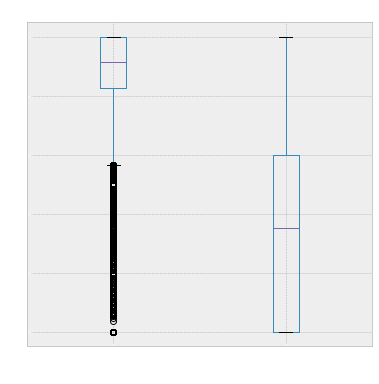

In [95]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenshtein_proc", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

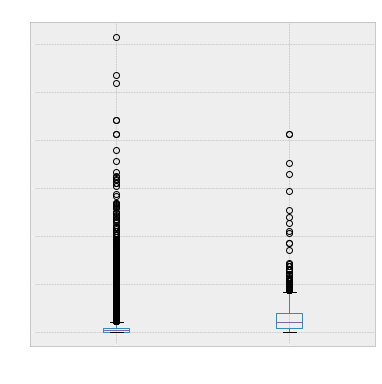

In [96]:
plt.figure(figsize=(6,6))

train.boxplot("num_equals_proc", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

In [97]:
from weighted_levenshtein import lev, osa, dam_lev

In [98]:
insert_costs = np.ones(128, dtype=np.float64)*0.5
delete_costs = np.ones(128, dtype=np.float64)*0.5
substitute_costs = np.ones((128, 128), dtype=np.float64)*2

In [99]:
train['weighted_lev'] = train.progress_apply(lambda r: lev(r.name_1, 
                                                           r.name_2, 
                                                           insert_costs=insert_costs, 
                                                           delete_costs=delete_costs, 
                                                           substitute_costs=substitute_costs), axis=1)           

100%|███████████████████████████████| 497819/497819 [00:34<00:00, 14374.96it/s]


In [100]:
test['weighted_lev'] = test.progress_apply(lambda r: lev(r.name_1, 
                                                           r.name_2, 
                                                           insert_costs=insert_costs, 
                                                           delete_costs=delete_costs, 
                                                           substitute_costs=substitute_costs), axis=1)  

100%|███████████████████████████████| 213249/213249 [00:14<00:00, 14437.16it/s]


In [101]:
#test['weighted_lev'] = test.progress_apply(lambda r: lev(r.name_1.encode('ascii', 'ignore'), r.name_2.encode('ascii', 'ignore'), substitute_costs=substitute_costs), axis=1)           

In [102]:
train['norm_ins_del'] = np.sqrt(train['num_ins_proc']**2 + train['num_del_proc']**2)
test['norm_ins_del'] = np.sqrt(test['num_ins_proc']**2 + test['num_del_proc']**2)

In [103]:
train['norm_weighted_lev'] = train['weighted_lev'] / (train['len_prod_proc'] + 1)
test['norm_weighted_lev'] = test['weighted_lev'] / (test['len_prod_proc'] + 1)

In [104]:
train['norm_weighted_lev_sum'] = train['weighted_lev'] / (train['len_sum_proc'] + 1)
test['norm_weighted_lev_sum'] = test['weighted_lev'] / (test['len_sum_proc'] + 1)

In [105]:
train[train.is_duplicate == 1].sample(10)

,name_1,name_2,is_duplicate,norm_levenshtein_proc,levenshtein_proc,num_ins_proc,num_del_proc,num_sub_proc,num_equals_proc,len_prod_proc,len_sum_proc,len_diff_proc,len_ratio_proc,levenstein_len_prod_ratio_proc,equals_len_prod_ratio_proc,weighted_lev,norm_ins_del,norm_weighted_lev,norm_weighted_lev_sum
pair_id,,,,,,,,,,,,,,,,,,,
375086,bridgestone firestone,bridgestone,1,0.476190,10.0,54,154,0,23,231,32,10,0.333333,0.043103,0.099138,5.0,163.193137,0.021552,0.151515
305653,bridgestone,bridgestone hosepower,1,0.476190,10.0,156,54,0,21,231,32,10,0.333333,0.043103,0.090517,5.0,165.081798,0.021552,0.151515
107707,exxonmobil,exxonmobil,1,0.000000,0.0,43,43,0,14,100,20,0,0.047619,0.000000,0.138614,0.0,60.811183,0.000000,0.000000
465397,reliance,reliance sibur,1,0.428571,6.0,73,27,0,12,112,22,6,0.304348,0.053097,0.106195,3.0,77.833155,0.026549,0.130435
314958,sika,sika,1,0.000000,0.0,6,6,0,4,16,8,0,0.111111,0.000000,0.235294,0.0,8.485281,0.000000,0.000000
17266,pavimental,pavimental,1,0.000000,0.0,44,44,0,12,100,20,0,0.047619,0.000000,0.118812,0.0,62.225397,0.000000,0.000000
75615,basf finlay,basf,1,0.636364,7.0,6,32,0,6,44,15,7,0.500000,0.155556,0.133333,3.5,32.557641,0.077778,0.218750
153867,arlanxeo,ktn underwood arlanxeo,1,0.636364,14.0,117,29,14,16,176,30,14,0.483871,0.079096,0.090395,7.0,120.540450,0.039548,0.225806
140120,contitech,contitech,1,0.000000,0.0,34,34,0,13,81,18,0,0.052632,0.000000,0.158537,0.0,48.083261,0.000000,0.000000


In [106]:
train[train.is_duplicate == 0].sample(10)

,name_1,name_2,is_duplicate,norm_levenshtein_proc,levenshtein_proc,num_ins_proc,num_del_proc,num_sub_proc,num_equals_proc,len_prod_proc,len_sum_proc,len_diff_proc,len_ratio_proc,levenstein_len_prod_ratio_proc,equals_len_prod_ratio_proc,weighted_lev,norm_ins_del,norm_weighted_lev,norm_weighted_lev_sum
pair_id,,,,,,,,,,,,,,,,,,,
126411,pico rivera warehouse,,0,1.000000,21.0,0,0,0,0,0,21,21,1.000000,21.000000,0.000000,10.5,0.000000,10.500000,0.477273
434304,alibesa,synthos kralupy,0,0.866667,13.0,68,21,11,5,105,22,8,0.391304,0.122642,0.047170,9.0,71.168813,0.084906,0.391304
444810,,msl,0,1.000000,3.0,0,0,0,0,0,3,3,1.000000,3.000000,0.000000,1.5,0.000000,1.500000,0.375000
470218,breg,trelleborg,0,0.700000,7.0,26,6,2,6,40,14,6,0.466667,0.170732,0.146341,4.0,26.683328,0.097561,0.266667
422272,cerealsoilsfoodstuffs foreign,foreign,0,0.758621,22.0,28,150,8,17,203,36,22,0.621622,0.107843,0.083333,11.0,152.590956,0.053922,0.297297
98064,indo rama,mill,0,1.000000,9.0,5,25,4,2,36,13,5,0.428571,0.243243,0.054054,5.5,25.495098,0.148649,0.392857
87462,foshan sanshui sanlian,,0,1.000000,22.0,0,0,0,0,0,22,22,1.000000,22.000000,0.000000,11.0,0.000000,11.000000,0.478261
485274,sspl,top,0,0.750000,3.0,3,6,2,1,12,7,1,0.250000,0.230769,0.076923,2.5,6.708204,0.192308,0.312500
96181,hongdan,han gia,0,0.571429,4.0,19,21,3,6,49,14,0,0.066667,0.080000,0.120000,3.0,28.319605,0.060000,0.200000


In [107]:
train[train.is_duplicate == 1].describe()

,is_duplicate,norm_levenshtein_proc,levenshtein_proc,num_ins_proc,num_del_proc,num_sub_proc,num_equals_proc,len_prod_proc,len_sum_proc,len_diff_proc,len_ratio_proc,levenstein_len_prod_ratio_proc,equals_len_prod_ratio_proc,weighted_lev,norm_ins_del,norm_weighted_lev,norm_weighted_lev_sum
count,3658.0,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000
mean,1.0,0.347065,5.840897,60.344177,57.299617,1.812192,13.009568,132.465555,20.796063,5.214325,0.331019,0.597346,0.115762,3.104155,90.037488,0.299965,0.127023
std,0.0,0.335900,6.861404,86.524369,88.749394,5.905230,13.261001,171.970112,12.991782,6.646592,0.306581,2.199098,0.072361,3.600118,119.081966,1.099279,0.134955
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,6.000000,6.000000,0.000000,4.000000,25.000000,11.000000,0.000000,0.076923,0.000000,0.082305,0.000000,14.142136,0.000000,0.000000
50%,1.0,0.352941,5.000000,33.000000,27.000000,0.000000,10.000000,81.000000,19.500000,4.000000,0.238095,0.028249,0.104762,2.500000,55.681699,0.016447,0.113636
75%,1.0,0.600000,10.000000,73.000000,66.000000,0.000000,19.000000,187.000000,30.000000,9.000000,0.466667,0.079509,0.153846,5.000000,127.953116,0.041096,0.206897
max,1.0,1.000000,77.000000,1447.000000,2538.000000,148.000000,206.000000,3690.000000,127.000000,77.000000,1.000000,20.000000,0.500000,38.500000,2707.873705,10.000000,0.476190


In [108]:
train[train.is_duplicate == 0].describe()

,is_duplicate,norm_levenshtein_proc,levenshtein_proc,num_ins_proc,num_del_proc,num_sub_proc,num_equals_proc,len_prod_proc,len_sum_proc,len_diff_proc,len_ratio_proc,levenstein_len_prod_ratio_proc,equals_len_prod_ratio_proc,weighted_lev,norm_ins_del,norm_weighted_lev,norm_weighted_lev_sum
count,494161.0,494161.000000,494161.000000,494161.000000,494161.00000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000,494161.000000
mean,0.0,0.875199,9.559648,19.560083,17.67479,4.279951,3.071440,44.586264,14.252610,7.249734,0.583644,3.118086,0.045146,5.636363,30.075238,1.579631,0.366424
std,0.0,0.186043,6.496370,39.134899,35.62904,5.816968,5.061945,71.888867,8.644963,6.853357,0.333916,5.731075,0.046895,3.416883,50.906223,2.855243,0.093399
min,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.826087,5.000000,0.000000,0.00000,0.000000,0.000000,0.000000,8.000000,2.000000,0.285714,0.140496,0.000000,3.500000,0.000000,0.095238,0.325000
50%,0.0,0.916667,8.000000,8.000000,6.00000,3.000000,2.000000,28.000000,13.000000,5.000000,0.529412,0.238095,0.040816,5.000000,17.204651,0.153061,0.380952
75%,0.0,1.000000,12.000000,23.000000,20.00000,6.000000,4.000000,60.000000,18.000000,10.000000,1.000000,5.000000,0.076923,7.000000,39.623226,2.500000,0.437500
max,0.0,1.000000,121.000000,4003.000000,2782.00000,306.000000,307.000000,5445.000000,166.000000,121.000000,1.000000,121.000000,0.500000,61.000000,4087.939579,60.500000,0.495902


In [109]:
train.columns

Index(['name_1', 'name_2', 'is_duplicate', 'norm_levenshtein_proc',
       'levenshtein_proc', 'num_ins_proc', 'num_del_proc', 'num_sub_proc',
       'num_equals_proc', 'len_prod_proc', 'len_sum_proc', 'len_diff_proc',
       'len_ratio_proc', 'levenstein_len_prod_ratio_proc',
       'equals_len_prod_ratio_proc', 'weighted_lev', 'norm_ins_del',
       'norm_weighted_lev', 'norm_weighted_lev_sum'],
      dtype='object')

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

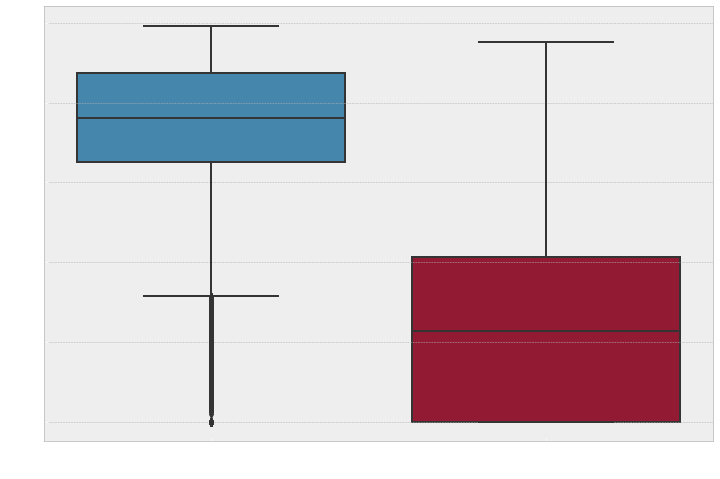

In [111]:
plt.figure(figsize=[12, 8])
sns.boxplot(data=train, x='is_duplicate', y='norm_weighted_lev_sum')

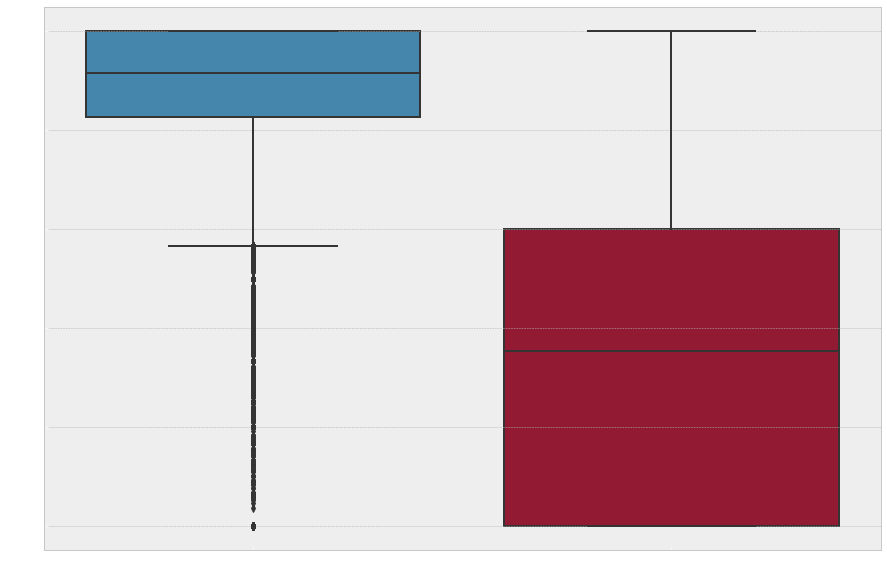

In [112]:
plt.figure(figsize=[15, 10])
sns.boxplot(data=train, x='is_duplicate', y='norm_levenshtein_proc')

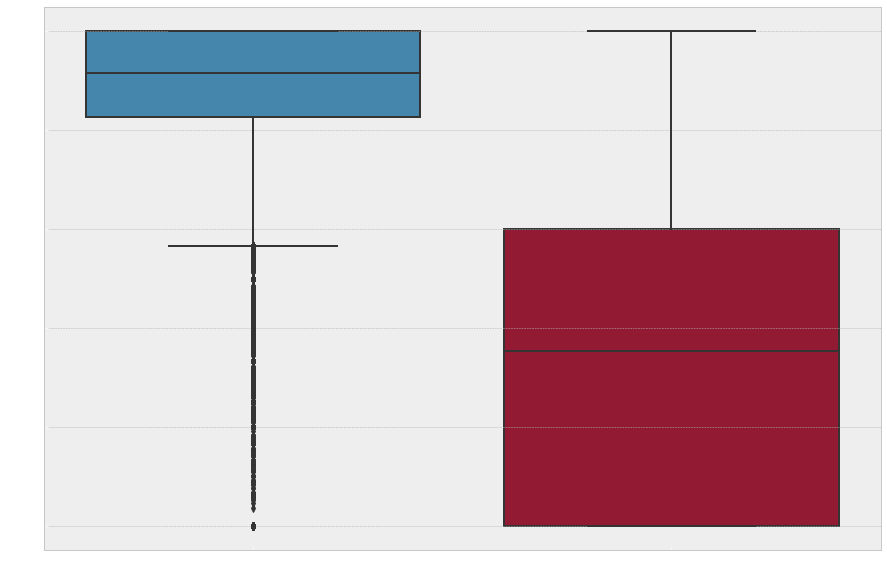

In [113]:
plt.figure(figsize=[15, 10])
sns.boxplot(data=train, x='is_duplicate', y='norm_levenshtein_proc')

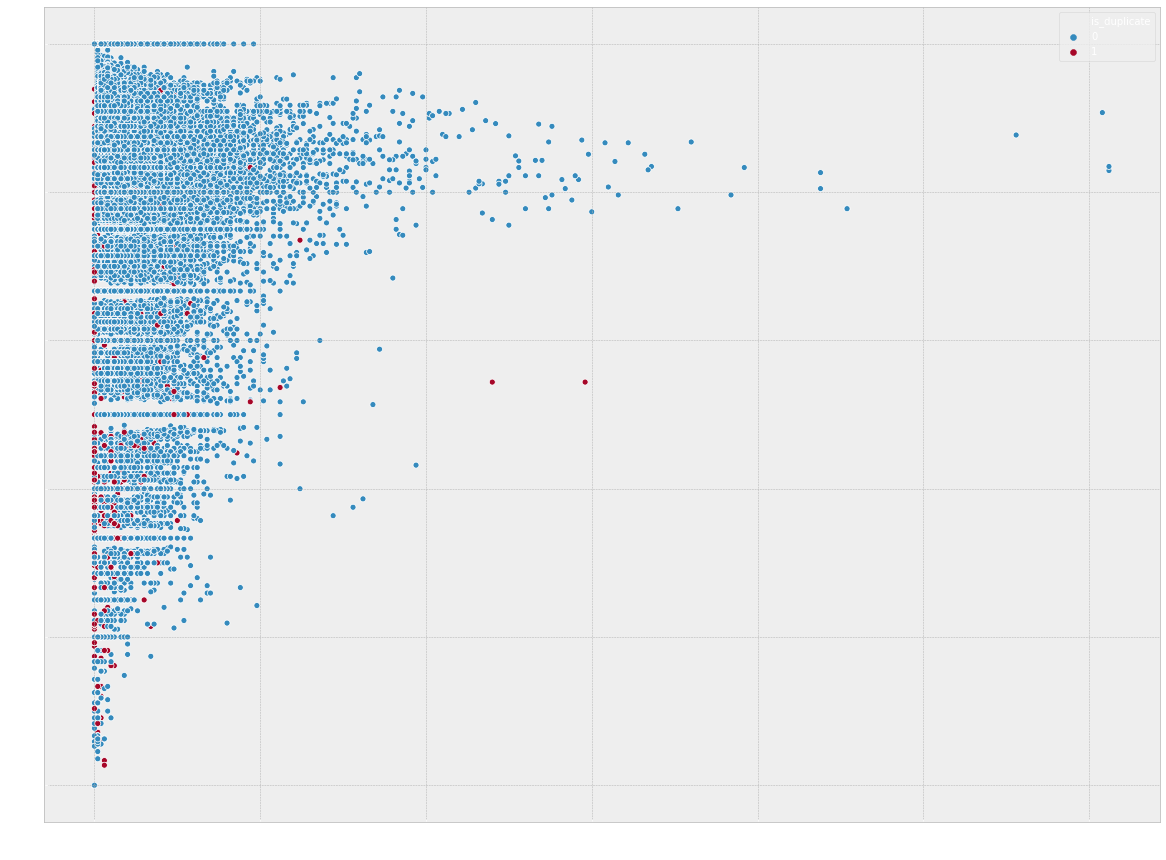

In [114]:
plt.figure(figsize=[20, 15])
sns.scatterplot(data=train, x='num_sub_proc', y='norm_levenshtein_proc', hue='is_duplicate')

# RF модель

In [ ]:
#from sklearn.model_selection import GridSearchCV

In [153]:
#clf = RandomForestClassifier(class_weight='balanced', random_state=RS)
#params = {'n_estimators': [100, 200, 300],
#          'max_depth':[10, 12, 15],
#          'min_samples_split': range(2,7,2), 
#          'min_samples_leaf': range(1,4),
#          'max_features': ['auto', 2]}
#gscv = GridSearchCV(clf, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)

In [ ]:
#gscv.fit(train[FTS].values, train["is_duplicate"].values)

In [122]:
#gscv.best_estimator_

In [123]:
#gscv.best_score_

In [124]:
#model = gscv.best_estimator_

In [125]:
###

In [126]:
FTS = ['norm_levenshtein_proc','num_equals_proc', 'num_sub_proc', 'norm_weighted_lev_sum',
       'equals_len_prod_ratio_proc', 'len_prod_proc', 'norm_weighted_lev', 'norm_ins_del']
THR = 0.9

In [141]:
split = StratifiedShuffleSplit(1, train_size=0.7, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [142]:
model = RandomForestClassifier(class_weight='balanced', max_depth=12,
                               min_samples_leaf=3, random_state=RS)
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=3, n_estimators=300, random_state=7345)

In [143]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [144]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [145]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    345912
           1       0.77      0.77      0.77      2561

    accuracy                           1.00    348473
   macro avg       0.89      0.88      0.88    348473
weighted avg       1.00      1.00      1.00    348473



In [146]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148249
           1       0.76      0.73      0.75      1097

    accuracy                           1.00    149346
   macro avg       0.88      0.86      0.87    149346
weighted avg       1.00      1.00      1.00    149346



In [147]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.7712495103799453
0.7458100558659219


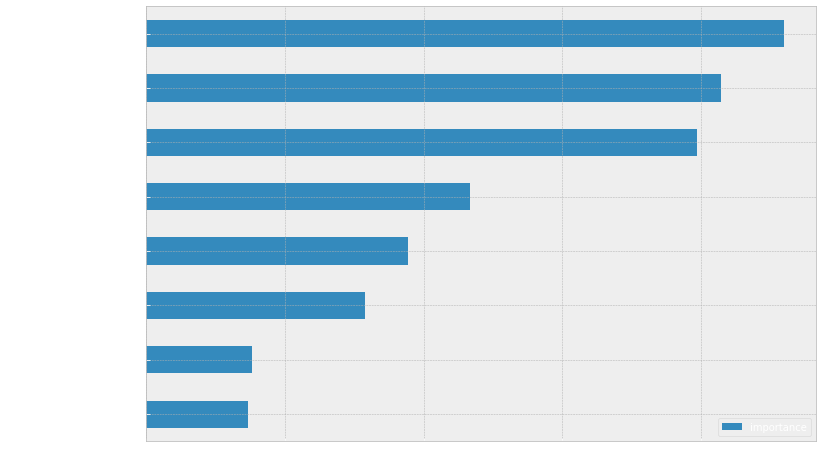

In [148]:
imp = pd.DataFrame(model.feature_importances_, index=FTS, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

# Генерация сабмита

In [135]:
#best_model = gscv.best_estimator_

In [136]:
sample_sub = pd.read_csv("sample_submission.csv", index_col="pair_id")

In [137]:
sample_sub

,is_duplicate
pair_id,
1,1
2,1
3,1
4,1
5,1
...,...
213245,1
213246,1
213247,1


In [149]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [150]:
sample_sub.is_duplicate.value_counts()

0    212150
1      1099
Name: is_duplicate, dtype: int64

In [151]:
sample_sub.to_csv("baseline_submission.csv")